In [1]:
import os,sys
import numpy as np
from collections import namedtuple
import tqdm
import glob
import math
import random
import inspect
import os.path as osp
from pathlib import Path
import itertools
from itertools import chain
import numpy as np
import pandas as pd
import multiprocessing
import h5py
import matplotlib.pyplot as plt
import numpy as np
import sys, os
from importlib import reload

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch_geometric.data import Data, DataLoader, DataListLoader
from torch_geometric.nn import EdgeConv, global_mean_pool, DataParallel
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.data import Data,Dataset
from torch_scatter import scatter_mean, scatter
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_geometric.nn import MetaLayer, EdgeConv, global_mean_pool, DynamicEdgeConv
import h5py

In [10]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

sys.path.append(os.path.abspath(os.path.join('../../')))
import vande.util.util_plotting as vande_plot
reload(vande_plot)

sys.path.append(os.path.abspath(os.path.join('../../')))
sys.path.append(os.path.abspath(os.path.join('../../DarkFlow/darkflow/')))
import DarkFlow.darkflow.networks.flows as flows

import models_torch.models as models
reload(models)
import models_torch.losses as losses
reload(losses)
import utils_torch.scaler
reload(utils_torch.scaler)
import utils_torch.preprocessing as prepr
import utils_torch.plot_util as plot
reload(plot)
import utils_torch.train_util as train
reload(train)
import graph_data.graph_data as graph_data
reload(graph_data)
import utils_torch.model_summary as summary
reload(summary)




<module 'utils_torch.model_summary' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils_torch/model_summary.py'>

In [9]:
data_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/'
dataset = graph_data.GraphDataset(root=data_dir,n_jets=1e3)
save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats/'
   
use_generator = False
if use_generator:
    validation_split = 0.2
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    if dataset_size > 2:
        split = int(np.floor(validation_split * dataset_size))
    else: 
        split = 1
    print(dataset_size,split)
    random_seed= 1001

    train_subset, val_subset = torch.utils.data.random_split(dataset, [dataset_size - split, split],
                                                             generator=torch.Generator().manual_seed(random_seed))
    print("train subset dim:", len(train_subset))
    print("validation subset dim", len(val_subset))
    dataloaders = {
        'train':  DataLoader(train_subset, batch_size=128, shuffle=True),
        'val':   DataLoader(val_subset, batch_size=128, shuffle=True)
    }
    print("train_dataloader dim:", len(dataloaders['train']))
    print("val dataloader dim:", len(dataloaders['val']))
else : 
    in_memory_datas = dataset.return_inmemory_data_no_loop() 

In [ ]:
pf_cands,jet_prop = dataset.pf_cands,dataset.jet_prop
pf_cands_t = torch.cat([torch.tensor(pf_cands[i], dtype=torch.float) for i in range(len(pf_cands))])
#Plot consistuents and jet features prepared for the graph! (but before any normalization)
pf_feats = 'px,py,pz,E,pt,eta,phi'.split(',')
jet_feats = 'N_constituents,M,Pt,Eta,Phi'.split(',')


save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats/'
vande_plot.plot_features(pf_cands_t.numpy(), pf_feats ,'Normalized' , 'QCD', plotname='{}plot_pf_feats_{}'.format(save_dir,'QCD_side'), legend=['QCD'], ylogscale=True)
vande_plot.plot_features(jet_prop[:,0:-1], jet_feats ,'Normalized' , 'QCD', plotname='{}plot_jet_feats_{}'.format(save_dir,'QCD_side'), legend=['QCD'], ylogscale=True)


In [11]:
#scaler = standardize(train_subset) # I dont think that this works for the dataset implementation as it is done now, implement scaler as part of dataset ? 
scaler = prepr.standardize(in_memory_datas,minmax_idx=[3,4],log_idx=[3,4]) 

dataloaders = {
    'train':  DataLoader(in_memory_datas, batch_size=128, shuffle=True)
    }
print("train_dataloader dim:", len(dataloaders['train']))

#dataset.get(0).u

train_dataloader dim: 8


In [ ]:
pf_cands_norm = torch.cat([torch.tensor(in_memory_datas[i].x, dtype=torch.float) for i in range(len(in_memory_datas))])
#Plot consistuents and jet features prepared for the graph! (after normalization)
pf_feats = 'px,py,pz,E,pt,eta,phi'.split(',')
save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats_normalized/'
vande_plot.plot_features(pf_cands_norm.numpy(), pf_feats ,'Normalized' , 'QCD', plotname='{}plot_pf_feats_{}'.format(save_dir,'QCD_side'), legend=['QCD'], ylogscale=True)


In [12]:
torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
multi_gpu = False #torch.cuda.device_count()>1

In [13]:
# model
input_dim = 7
output_dim = 4#7#4#4,7
big_dim = 32
hidden_dim = 2
#model = models.EdgeNet(input_dim=input_dim,output_dim=output_dim, big_dim=big_dim, hidden_dim=hidden_dim)
#model = models.EdgeNetVAE(input_dim=input_dim,output_dim=output_dim, big_dim=big_dim, hidden_dim=hidden_dim)
model = models.PlanarEdgeNetVAE(input_dim=input_dim,output_dim=output_dim, big_dim=big_dim, hidden_dim=hidden_dim)

optimizer = torch.optim.Adam(model.parameters(), lr = 10e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, threshold=1e-6)

model.to(device)
print(model)
summary.gnn_model_summary(model)

PlanarEdgeNetVAE(
  (mu_layer): Linear(in_features=32, out_features=2, bias=True)
  (var_layer): Linear(in_features=32, out_features=2, bias=True)
  (batchnorm): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): EdgeConv(nn=Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ELU(alpha=1.0)
  ))
  (decoder): EdgeConv(nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=32, out_features=4, bias=True)
  ))
  (amor_u): Linear(in_features=32, out_features=12, bias=True)
  (amor_w): Linear(in_features=32, out_features=12, bias=True)
  (amor_b): Linear(in_features=32, out_features=6, bias=True)
  (flow_0): Planar(
    (h): Tanh()
    (softplus): Softplus(beta=1, threshold=20)
  )
  (flo

In [21]:
#loss
#loss_ftn_obj = losses.LossFunction('mse_coordinates', device=device)
#loss_ftn_obj = losses.LossFunction('mse', device=device)
#loss_ftn_obj = losses.LossFunction('vae_loss_mse',beta=0.00001,device=device)
loss_ftn_obj = losses.LossFunction('vae_loss_mse_coord',beta=0.5,device=device)

# Training loop
n_epochs = 80
stale_epochs = 0
loss = 999999
#train_losses = []
for epoch in range(0, n_epochs):
    #loss = train(model, optimizer, loader, len(datas), 128, loss_ftn_obj)
    loss_tot,loss_reco,loss_kl = train.train(model, optimizer, dataloaders['train'], len(dataloaders['train'].dataset), dataloaders['train'].batch_size, loss_ftn_obj)
    #train_losses.append(loss)
    print('Epoch: {:02d}, Training Loss Tot, Reco, KL :  {:.4f},{:.4f}, {:.4f}'.format(epoch, loss_tot,loss_reco,loss_kl))

train loss tot = 0.1165649,train loss reco = 0.2277535,train loss kl = 0.0053764: : 8it [00:00, 10.58it/s]                          
train loss tot = 0.1291443,train loss reco = 0.2538319,train loss kl = 0.0044567:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.54it/s]

Epoch: 00, Training Loss Tot, Reco, KL :  0.1142,0.2226, 0.0059


train loss tot = 0.1083154,train loss reco = 0.1950060,train loss kl = 0.0216248: : 8it [00:00, 10.74it/s]                          
train loss tot = 0.1282611,train loss reco = 0.2396576,train loss kl = 0.0168646:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.63it/s]

Epoch: 01, Training Loss Tot, Reco, KL :  0.1130,0.2147, 0.0114


train loss tot = 0.1383648,train loss reco = 0.2575407,train loss kl = 0.0191889: : 8it [00:00, 10.64it/s]                          
train loss tot = 0.1166342,train loss reco = 0.2185357,train loss kl = 0.0147328:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.68it/s]

Epoch: 02, Training Loss Tot, Reco, KL :  0.1197,0.2187, 0.0208


train loss tot = 0.1017790,train loss reco = 0.1952623,train loss kl = 0.0082957: : 8it [00:00, 10.87it/s]                          
train loss tot = 0.1227887,train loss reco = 0.2385845,train loss kl = 0.0069929:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.67it/s]

Epoch: 03, Training Loss Tot, Reco, KL :  0.1115,0.2108, 0.0122


train loss tot = 0.1223491,train loss reco = 0.2404807,train loss kl = 0.0042174: : 8it [00:00, 10.88it/s]                          
train loss tot = 0.0919192,train loss reco = 0.1803012,train loss kl = 0.0035373:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.65it/s]

Epoch: 04, Training Loss Tot, Reco, KL :  0.1121,0.2182, 0.0061


train loss tot = 0.1197062,train loss reco = 0.2356311,train loss kl = 0.0037814: : 8it [00:00, 10.86it/s]                          
train loss tot = 0.1108510,train loss reco = 0.2177920,train loss kl = 0.0039099:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.72it/s]

Epoch: 05, Training Loss Tot, Reco, KL :  0.1080,0.2124, 0.0037


train loss tot = 0.1200147,train loss reco = 0.2371549,train loss kl = 0.0028745: : 8it [00:00, 10.89it/s]                          
train loss tot = 0.0891204,train loss reco = 0.1750052,train loss kl = 0.0032356:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.64it/s]

Epoch: 06, Training Loss Tot, Reco, KL :  0.1092,0.2150, 0.0034


train loss tot = 0.1044319,train loss reco = 0.2045060,train loss kl = 0.0043579: : 8it [00:00, 10.86it/s]                          
train loss tot = 0.1071216,train loss reco = 0.2094403,train loss kl = 0.0048030:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.66it/s]

Epoch: 07, Training Loss Tot, Reco, KL :  0.1082,0.2132, 0.0032


train loss tot = 0.1204957,train loss reco = 0.2314850,train loss kl = 0.0095065: : 8it [00:00, 10.86it/s]                          
train loss tot = 0.1281165,train loss reco = 0.2462449,train loss kl = 0.0099881:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.69it/s]

Epoch: 08, Training Loss Tot, Reco, KL :  0.1136,0.2209, 0.0062


train loss tot = 0.1122937,train loss reco = 0.2149444,train loss kl = 0.0096430: : 8it [00:00, 10.83it/s]                          
train loss tot = 0.1057847,train loss reco = 0.2042460,train loss kl = 0.0073234:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.57it/s]

Epoch: 09, Training Loss Tot, Reco, KL :  0.1136,0.2162, 0.0110


train loss tot = 0.1434214,train loss reco = 0.2795466,train loss kl = 0.0072961: : 8it [00:00, 10.80it/s]                          
train loss tot = 0.1323975,train loss reco = 0.2559142,train loss kl = 0.0088809:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.65it/s]

Epoch: 10, Training Loss Tot, Reco, KL :  0.1122,0.2158, 0.0086


train loss tot = 0.1031173,train loss reco = 0.2012275,train loss kl = 0.0050071: : 8it [00:00, 10.80it/s]                          
train loss tot = 0.1056584,train loss reco = 0.2074475,train loss kl = 0.0038693:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.63it/s]

Epoch: 11, Training Loss Tot, Reco, KL :  0.1086,0.2107, 0.0065


train loss tot = 0.0976738,train loss reco = 0.1918038,train loss kl = 0.0035437: : 8it [00:00, 10.68it/s]                          
train loss tot = 0.1096402,train loss reco = 0.2157718,train loss kl = 0.0035087:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.67it/s]

Epoch: 12, Training Loss Tot, Reco, KL :  0.1074,0.2109, 0.0040


train loss tot = 0.1017014,train loss reco = 0.1997402,train loss kl = 0.0036625: : 8it [00:00, 10.87it/s]                          
train loss tot = 0.1176782,train loss reco = 0.2316156,train loss kl = 0.0037408:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.68it/s]

Epoch: 13, Training Loss Tot, Reco, KL :  0.1077,0.2117, 0.0037


train loss tot = 0.1021533,train loss reco = 0.2011164,train loss kl = 0.0031903: : 8it [00:00, 10.87it/s]                          
train loss tot = 0.1164677,train loss reco = 0.2216031,train loss kl = 0.0113324:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.66it/s]

Epoch: 14, Training Loss Tot, Reco, KL :  0.1078,0.2118, 0.0038


train loss tot = 0.1213612,train loss reco = 0.2348364,train loss kl = 0.0078861: : 8it [00:00, 10.85it/s]                          
train loss tot = 0.1547210,train loss reco = 0.2942338,train loss kl = 0.0152082:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.67it/s]

Epoch: 15, Training Loss Tot, Reco, KL :  0.1238,0.2382, 0.0094


train loss tot = 0.1047940,train loss reco = 0.2033358,train loss kl = 0.0062523: : 8it [00:00, 10.87it/s]                          
train loss tot = 0.1354336,train loss reco = 0.2618878,train loss kl = 0.0089795:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.75it/s]

Epoch: 16, Training Loss Tot, Reco, KL :  0.1285,0.2485, 0.0085


train loss tot = 0.1145754,train loss reco = 0.2142135,train loss kl = 0.0149373: : 8it [00:00, 10.89it/s]                          
train loss tot = 0.1032023,train loss reco = 0.1931849,train loss kl = 0.0132197:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.60it/s]

Epoch: 17, Training Loss Tot, Reco, KL :  0.1236,0.2384, 0.0088


train loss tot = 0.1280340,train loss reco = 0.2448253,train loss kl = 0.0112428: : 8it [00:00, 10.77it/s]                          
train loss tot = 0.1253252,train loss reco = 0.2453787,train loss kl = 0.0052716:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.71it/s]

Epoch: 18, Training Loss Tot, Reco, KL :  0.1160,0.2216, 0.0104


train loss tot = 0.1311383,train loss reco = 0.2571347,train loss kl = 0.0051419: : 8it [00:00, 10.85it/s]                          
train loss tot = 0.0944360,train loss reco = 0.1840773,train loss kl = 0.0047948:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.66it/s]

Epoch: 19, Training Loss Tot, Reco, KL :  0.1112,0.2160, 0.0064


train loss tot = 0.1109067,train loss reco = 0.2182840,train loss kl = 0.0035293: : 8it [00:00, 10.87it/s]                          
train loss tot = 0.1020254,train loss reco = 0.2009794,train loss kl = 0.0030715:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.68it/s]

Epoch: 20, Training Loss Tot, Reco, KL :  0.1032,0.2006, 0.0058


train loss tot = 0.1069229,train loss reco = 0.2113524,train loss kl = 0.0024933: : 8it [00:00, 10.83it/s]                          
train loss tot = 0.0995011,train loss reco = 0.1964356,train loss kl = 0.0025666:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.64it/s]

Epoch: 21, Training Loss Tot, Reco, KL :  0.1018,0.2007, 0.0030


train loss tot = 0.1200944,train loss reco = 0.2375056,train loss kl = 0.0026833: : 8it [00:00, 10.81it/s]                          
train loss tot = 0.1030820,train loss reco = 0.2037322,train loss kl = 0.0024317:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.68it/s]

Epoch: 22, Training Loss Tot, Reco, KL :  0.1036,0.2047, 0.0025


train loss tot = 0.1054839,train loss reco = 0.2088991,train loss kl = 0.0020687: : 8it [00:00, 10.81it/s]                          
train loss tot = 0.1197899,train loss reco = 0.2376080,train loss kl = 0.0019719:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.59it/s]

Epoch: 23, Training Loss Tot, Reco, KL :  0.1053,0.2082, 0.0024


train loss tot = 0.0862831,train loss reco = 0.1698671,train loss kl = 0.0026992: : 8it [00:00, 10.81it/s]                          
train loss tot = 0.1056379,train loss reco = 0.2070087,train loss kl = 0.0042671:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.62it/s]

Epoch: 24, Training Loss Tot, Reco, KL :  0.1027,0.2033, 0.0022


train loss tot = 0.0975656,train loss reco = 0.1900462,train loss kl = 0.0050850: : 8it [00:00, 10.83it/s]                          
train loss tot = 0.0989939,train loss reco = 0.1932580,train loss kl = 0.0047297:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.65it/s]

Epoch: 25, Training Loss Tot, Reco, KL :  0.1023,0.1999, 0.0048


train loss tot = 0.1100489,train loss reco = 0.2170901,train loss kl = 0.0030076: : 8it [00:00, 10.83it/s]                          
train loss tot = 0.1072507,train loss reco = 0.2112683,train loss kl = 0.0032330:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.63it/s]

Epoch: 26, Training Loss Tot, Reco, KL :  0.1028,0.2013, 0.0043


train loss tot = 0.0985364,train loss reco = 0.1950219,train loss kl = 0.0020508: : 8it [00:00, 10.62it/s]                          
train loss tot = 0.0895925,train loss reco = 0.1772518,train loss kl = 0.0019331:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.29it/s]

Epoch: 27, Training Loss Tot, Reco, KL :  0.1040,0.2056, 0.0025


train loss tot = 0.1133037,train loss reco = 0.2247158,train loss kl = 0.0018916: : 8it [00:00, 10.69it/s]                          
train loss tot = 0.1048228,train loss reco = 0.2075455,train loss kl = 0.0021002:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.67it/s]

Epoch: 28, Training Loss Tot, Reco, KL :  0.1003,0.1986, 0.0019


train loss tot = 0.1004574,train loss reco = 0.1992174,train loss kl = 0.0016974: : 8it [00:00, 10.85it/s]                          
train loss tot = 0.0933639,train loss reco = 0.1849665,train loss kl = 0.0017614:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.61it/s]

Epoch: 29, Training Loss Tot, Reco, KL :  0.1023,0.2027, 0.0019


train loss tot = 0.1112381,train loss reco = 0.2212709,train loss kl = 0.0012053: : 8it [00:00, 10.82it/s]                          
train loss tot = 0.0918782,train loss reco = 0.1823203,train loss kl = 0.0014360:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.67it/s]

Epoch: 30, Training Loss Tot, Reco, KL :  0.1037,0.2058, 0.0016


train loss tot = 0.1001318,train loss reco = 0.1988956,train loss kl = 0.0013679: : 8it [00:00, 10.84it/s]                          
train loss tot = 0.0905012,train loss reco = 0.1794456,train loss kl = 0.0015567:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.60it/s]

Epoch: 31, Training Loss Tot, Reco, KL :  0.1009,0.2003, 0.0016


train loss tot = 0.1044846,train loss reco = 0.2076622,train loss kl = 0.0013070: : 8it [00:00, 10.83it/s]                          
train loss tot = 0.1190974,train loss reco = 0.2368086,train loss kl = 0.0013862:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.62it/s]

Epoch: 32, Training Loss Tot, Reco, KL :  0.1024,0.2034, 0.0015


train loss tot = 0.1142105,train loss reco = 0.2213434,train loss kl = 0.0070775: : 8it [00:00, 10.81it/s]                          
train loss tot = 0.1128559,train loss reco = 0.2180642,train loss kl = 0.0076476:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.61it/s]

Epoch: 33, Training Loss Tot, Reco, KL :  0.1033,0.2039, 0.0028


train loss tot = 0.1020424,train loss reco = 0.1978212,train loss kl = 0.0062635: : 8it [00:00, 10.83it/s]                          
train loss tot = 0.1205401,train loss reco = 0.2361490,train loss kl = 0.0049311:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.64it/s]

Epoch: 34, Training Loss Tot, Reco, KL :  0.1074,0.2072, 0.0076


train loss tot = 0.3231854,train loss reco = 0.2804706,train loss kl = 0.3659002: : 8it [00:00, 10.84it/s]                          
train loss tot = 0.3712652,train loss reco = 0.3353159,train loss kl = 0.4072144:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.63it/s]

Epoch: 35, Training Loss Tot, Reco, KL :  0.1578,0.2302, 0.0854


train loss tot = 0.2097323,train loss reco = 0.2613031,train loss kl = 0.1581615: : 8it [00:00, 10.83it/s]                          
train loss tot = 0.1662516,train loss reco = 0.2404657,train loss kl = 0.0920374:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.65it/s]

Epoch: 36, Training Loss Tot, Reco, KL :  0.2863,0.2864, 0.2862


train loss tot = 0.1495976,train loss reco = 0.2454356,train loss kl = 0.0537597: : 8it [00:00, 10.84it/s]                          
train loss tot = 0.1561032,train loss reco = 0.2668699,train loss kl = 0.0453365:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.70it/s]

Epoch: 37, Training Loss Tot, Reco, KL :  0.1715,0.2545, 0.0884


train loss tot = 0.1157914,train loss reco = 0.1878274,train loss kl = 0.0437553: : 8it [00:00, 10.83it/s]                          
train loss tot = 0.1324717,train loss reco = 0.2275652,train loss kl = 0.0373781:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.71it/s]

Epoch: 38, Training Loss Tot, Reco, KL :  0.1352,0.2257, 0.0447


train loss tot = 0.1180140,train loss reco = 0.2058925,train loss kl = 0.0301355: : 8it [00:00, 10.87it/s]                          
train loss tot = 0.1019819,train loss reco = 0.1796155,train loss kl = 0.0243483:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.71it/s]

Epoch: 39, Training Loss Tot, Reco, KL :  0.1256,0.2136, 0.0377


train loss tot = 0.1228460,train loss reco = 0.2315503,train loss kl = 0.0141417: : 8it [00:00, 10.86it/s]                          
train loss tot = 0.1020376,train loss reco = 0.1911426,train loss kl = 0.0129326:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.69it/s]

Epoch: 40, Training Loss Tot, Reco, KL :  0.1154,0.2113, 0.0196


train loss tot = 0.1193330,train loss reco = 0.2110246,train loss kl = 0.0276415: : 8it [00:00, 10.90it/s]                          
train loss tot = 0.1223341,train loss reco = 0.2120865,train loss kl = 0.0325817:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.70it/s]

Epoch: 41, Training Loss Tot, Reco, KL :  0.1177,0.2098, 0.0256


train loss tot = 0.1353477,train loss reco = 0.2432103,train loss kl = 0.0274850: : 8it [00:00, 10.71it/s]                          
train loss tot = 0.1416388,train loss reco = 0.2594696,train loss kl = 0.0238080:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.47it/s]

Epoch: 42, Training Loss Tot, Reco, KL :  0.1209,0.2108, 0.0310


train loss tot = 0.1291547,train loss reco = 0.2327431,train loss kl = 0.0255663: : 8it [00:00, 10.76it/s]                          
train loss tot = 0.1075584,train loss reco = 0.1870669,train loss kl = 0.0280500:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.57it/s]

Epoch: 43, Training Loss Tot, Reco, KL :  0.1190,0.2117, 0.0262


train loss tot = 0.1125801,train loss reco = 0.2060221,train loss kl = 0.0191382: : 8it [00:00, 10.81it/s]                          
train loss tot = 0.1087001,train loss reco = 0.2001471,train loss kl = 0.0172530:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.62it/s]

Epoch: 44, Training Loss Tot, Reco, KL :  0.1125,0.1985, 0.0265


train loss tot = 0.1103245,train loss reco = 0.2080925,train loss kl = 0.0125566: : 8it [00:00, 10.86it/s]                          
train loss tot = 0.0960152,train loss reco = 0.1831696,train loss kl = 0.0088608:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.68it/s]

Epoch: 45, Training Loss Tot, Reco, KL :  0.1054,0.1966, 0.0142


train loss tot = 0.0882642,train loss reco = 0.1695271,train loss kl = 0.0070013: : 8it [00:00, 10.89it/s]                          
train loss tot = 0.0995407,train loss reco = 0.1913975,train loss kl = 0.0076838:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.68it/s]

Epoch: 46, Training Loss Tot, Reco, KL :  0.1008,0.1932, 0.0084


train loss tot = 0.1090780,train loss reco = 0.2112088,train loss kl = 0.0069473: : 8it [00:00, 10.90it/s]                          
train loss tot = 0.0955485,train loss reco = 0.1836927,train loss kl = 0.0074042:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.70it/s]

Epoch: 47, Training Loss Tot, Reco, KL :  0.1001,0.1929, 0.0074


train loss tot = 0.1087376,train loss reco = 0.2118151,train loss kl = 0.0056601: : 8it [00:00, 10.89it/s]                          
train loss tot = 0.0985582,train loss reco = 0.1921569,train loss kl = 0.0049594:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.63it/s]

Epoch: 48, Training Loss Tot, Reco, KL :  0.0991,0.1917, 0.0066


train loss tot = 0.1052708,train loss reco = 0.2056399,train loss kl = 0.0049017: : 8it [00:00, 10.83it/s]                          
train loss tot = 0.1074812,train loss reco = 0.2103491,train loss kl = 0.0046133:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.67it/s]

Epoch: 49, Training Loss Tot, Reco, KL :  0.0987,0.1925, 0.0050


train loss tot = 0.0808438,train loss reco = 0.1576170,train loss kl = 0.0040707: : 8it [00:00, 10.82it/s]                          
train loss tot = 0.1024855,train loss reco = 0.2010046,train loss kl = 0.0039664:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.71it/s]

Epoch: 50, Training Loss Tot, Reco, KL :  0.0986,0.1930, 0.0042


train loss tot = 0.0953032,train loss reco = 0.1850493,train loss kl = 0.0055570: : 8it [00:00, 10.85it/s]                          
train loss tot = 0.1145097,train loss reco = 0.2238076,train loss kl = 0.0052118:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.57it/s]

Epoch: 51, Training Loss Tot, Reco, KL :  0.0994,0.1942, 0.0046


train loss tot = 0.1049967,train loss reco = 0.2057190,train loss kl = 0.0042743: : 8it [00:00, 10.83it/s]                          
train loss tot = 0.1016953,train loss reco = 0.1994548,train loss kl = 0.0039358:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.62it/s]

Epoch: 52, Training Loss Tot, Reco, KL :  0.1040,0.2031, 0.0049


train loss tot = 0.1057170,train loss reco = 0.2079314,train loss kl = 0.0035026: : 8it [00:00, 10.84it/s]                          
train loss tot = 0.0964356,train loss reco = 0.1896987,train loss kl = 0.0031724:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.62it/s]

Epoch: 53, Training Loss Tot, Reco, KL :  0.1019,0.2000, 0.0039


train loss tot = 0.1002062,train loss reco = 0.1969295,train loss kl = 0.0034828: : 8it [00:00, 10.84it/s]                          
train loss tot = 0.0911359,train loss reco = 0.1790921,train loss kl = 0.0031796:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.62it/s]

Epoch: 54, Training Loss Tot, Reco, KL :  0.0998,0.1956, 0.0040


train loss tot = 0.1028319,train loss reco = 0.2025665,train loss kl = 0.0030972: : 8it [00:00, 10.81it/s]                          
train loss tot = 0.0932422,train loss reco = 0.1832937,train loss kl = 0.0031906:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.56it/s]

Epoch: 55, Training Loss Tot, Reco, KL :  0.1021,0.2008, 0.0034


train loss tot = 0.0915525,train loss reco = 0.1802977,train loss kl = 0.0028073: : 8it [00:00, 10.80it/s]                          
train loss tot = 0.0855986,train loss reco = 0.1684012,train loss kl = 0.0027959:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.58it/s]

Epoch: 56, Training Loss Tot, Reco, KL :  0.0991,0.1951, 0.0031


train loss tot = 0.1037731,train loss reco = 0.2046891,train loss kl = 0.0028572: : 8it [00:00, 10.82it/s]                          
train loss tot = 0.1069253,train loss reco = 0.2112234,train loss kl = 0.0026273:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.63it/s]

Epoch: 57, Training Loss Tot, Reco, KL :  0.0973,0.1919, 0.0028


train loss tot = 0.0901250,train loss reco = 0.1766017,train loss kl = 0.0036482: : 8it [00:00, 10.80it/s]                          
train loss tot = 0.1062624,train loss reco = 0.2090439,train loss kl = 0.0034809:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.65it/s]

Epoch: 58, Training Loss Tot, Reco, KL :  0.1010,0.1991, 0.0029


train loss tot = 0.0772207,train loss reco = 0.1504263,train loss kl = 0.0040152: : 8it [00:00, 10.84it/s]                          
train loss tot = 0.0950009,train loss reco = 0.1862794,train loss kl = 0.0037223:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.46it/s]

Epoch: 59, Training Loss Tot, Reco, KL :  0.1011,0.1982, 0.0040


train loss tot = 0.0851682,train loss reco = 0.1675709,train loss kl = 0.0027655: : 8it [00:00, 10.63it/s]                          
train loss tot = 0.0998332,train loss reco = 0.1970230,train loss kl = 0.0026434:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.69it/s]

Epoch: 60, Training Loss Tot, Reco, KL :  0.0969,0.1905, 0.0033


train loss tot = 0.0932066,train loss reco = 0.1841665,train loss kl = 0.0022467: : 8it [00:00, 10.79it/s]                          
train loss tot = 0.1127828,train loss reco = 0.2232919,train loss kl = 0.0022737:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.63it/s]

Epoch: 61, Training Loss Tot, Reco, KL :  0.0956,0.1887, 0.0025


train loss tot = 0.1136245,train loss reco = 0.2245575,train loss kl = 0.0026915: : 8it [00:00, 10.83it/s]                          
train loss tot = 0.1036045,train loss reco = 0.2043105,train loss kl = 0.0028984:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.63it/s]

Epoch: 62, Training Loss Tot, Reco, KL :  0.1003,0.1982, 0.0024


train loss tot = 0.1375083,train loss reco = 0.2692870,train loss kl = 0.0057296: : 8it [00:00, 10.82it/s]                          
train loss tot = 0.1112421,train loss reco = 0.2183010,train loss kl = 0.0041833:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.38it/s]

Epoch: 63, Training Loss Tot, Reco, KL :  0.1172,0.2307, 0.0037


train loss tot = 0.1202010,train loss reco = 0.2370218,train loss kl = 0.0033801: : 8it [00:00, 10.73it/s]                          
train loss tot = 0.1186110,train loss reco = 0.2329160,train loss kl = 0.0043060:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.65it/s]

Epoch: 64, Training Loss Tot, Reco, KL :  0.1230,0.2421, 0.0039


train loss tot = 0.0989197,train loss reco = 0.1936518,train loss kl = 0.0041876: : 8it [00:00, 10.81it/s]                          
train loss tot = 0.1480867,train loss reco = 0.2886323,train loss kl = 0.0075411:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.61it/s]

Epoch: 65, Training Loss Tot, Reco, KL :  0.1178,0.2311, 0.0044


train loss tot = 0.1187881,train loss reco = 0.2233588,train loss kl = 0.0142175: : 8it [00:00, 10.81it/s]                          
train loss tot = 0.1105611,train loss reco = 0.2102529,train loss kl = 0.0108693:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.69it/s]

Epoch: 66, Training Loss Tot, Reco, KL :  0.1145,0.2176, 0.0113


train loss tot = 0.1388986,train loss reco = 0.2675048,train loss kl = 0.0102925: : 8it [00:00, 10.83it/s]                          
train loss tot = 0.0985609,train loss reco = 0.1878663,train loss kl = 0.0092555:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.62it/s]

Epoch: 67, Training Loss Tot, Reco, KL :  0.1097,0.2098, 0.0096


train loss tot = 0.1553645,train loss reco = 0.3027134,train loss kl = 0.0080156: : 8it [00:00, 10.69it/s]                          
train loss tot = 0.1146087,train loss reco = 0.2203755,train loss kl = 0.0088419:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.70it/s]

Epoch: 68, Training Loss Tot, Reco, KL :  0.1137,0.2185, 0.0090


train loss tot = 0.1226895,train loss reco = 0.2368299,train loss kl = 0.0085491: : 8it [00:00, 10.86it/s]                          
train loss tot = 0.1131668,train loss reco = 0.2181377,train loss kl = 0.0081958:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.67it/s]

Epoch: 69, Training Loss Tot, Reco, KL :  0.1328,0.2570, 0.0086


train loss tot = 0.1190874,train loss reco = 0.2309958,train loss kl = 0.0071791: : 8it [00:00, 10.88it/s]                          
train loss tot = 0.1173653,train loss reco = 0.2306571,train loss kl = 0.0040736:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.72it/s]

Epoch: 70, Training Loss Tot, Reco, KL :  0.1273,0.2468, 0.0077


train loss tot = 0.1245507,train loss reco = 0.2459461,train loss kl = 0.0031552: : 8it [00:00, 10.89it/s]                          
train loss tot = 0.1159109,train loss reco = 0.2265777,train loss kl = 0.0052441:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.73it/s]

Epoch: 71, Training Loss Tot, Reco, KL :  0.1186,0.2326, 0.0046


train loss tot = 0.1255188,train loss reco = 0.2459494,train loss kl = 0.0050881: : 8it [00:00, 10.90it/s]                          
train loss tot = 0.1265026,train loss reco = 0.2495143,train loss kl = 0.0034909:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.69it/s]

Epoch: 72, Training Loss Tot, Reco, KL :  0.1156,0.2265, 0.0048


train loss tot = 0.0896768,train loss reco = 0.1762605,train loss kl = 0.0030930: : 8it [00:00, 10.90it/s]                          
train loss tot = 0.0913230,train loss reco = 0.1806338,train loss kl = 0.0020121:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.63it/s]

Epoch: 73, Training Loss Tot, Reco, KL :  0.1149,0.2262, 0.0035


train loss tot = 0.0909104,train loss reco = 0.1790320,train loss kl = 0.0027889: : 8it [00:00, 10.88it/s]                          
train loss tot = 0.1190844,train loss reco = 0.2337695,train loss kl = 0.0043993:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.76it/s]

Epoch: 74, Training Loss Tot, Reco, KL :  0.1055,0.2084, 0.0026


train loss tot = 0.1159686,train loss reco = 0.2288399,train loss kl = 0.0030974: : 8it [00:00, 10.90it/s]                          
train loss tot = 0.0961105,train loss reco = 0.1897184,train loss kl = 0.0025026:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.66it/s]

Epoch: 75, Training Loss Tot, Reco, KL :  0.1091,0.2147, 0.0035


train loss tot = 0.1106450,train loss reco = 0.2187526,train loss kl = 0.0025374: : 8it [00:00, 10.84it/s]                          
train loss tot = 0.0897255,train loss reco = 0.1770751,train loss kl = 0.0023759:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.58it/s]

Epoch: 76, Training Loss Tot, Reco, KL :  0.1055,0.2084, 0.0026


train loss tot = 0.1125892,train loss reco = 0.2163402,train loss kl = 0.0088383: : 8it [00:00, 10.76it/s]                          
train loss tot = 0.1121942,train loss reco = 0.2143632,train loss kl = 0.0100252:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.59it/s]

Epoch: 77, Training Loss Tot, Reco, KL :  0.1040,0.2010, 0.0070


train loss tot = 0.0966403,train loss reco = 0.1892199,train loss kl = 0.0040608: : 8it [00:00, 10.76it/s]                          
train loss tot = 0.0871081,train loss reco = 0.1703146,train loss kl = 0.0039016:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.51it/s]

Epoch: 78, Training Loss Tot, Reco, KL :  0.1054,0.2038, 0.0069


train loss tot = 0.0845744,train loss reco = 0.1642544,train loss kl = 0.0048944: : 8it [00:00, 10.68it/s]                          

Epoch: 79, Training Loss Tot, Reco, KL :  0.1008,0.1976, 0.0040


In [26]:
reload(utils_torch.scaler)
reload(prepr)
reload(plot)

save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats/'
inverse_standardization = True
plot.plot_reco_for_loader(model, dataloaders['train'], device, scaler, inverse_standardization, 'test_train', osp.join(save_dir, 'reconstruction_post_train', 'train_reco_std_log_minmax_vae_planar_mseconv_kl_elu'), 'all_mseconv')


In [22]:
latent = plot.gen_latent(model, dataloaders['train'], device)


In [23]:
mu_fts,log_var_fts,z_0_fts,z_last_fts = latent

In [18]:
#!{sys.executable} -m pip install seaborn
#import seaborn as sns


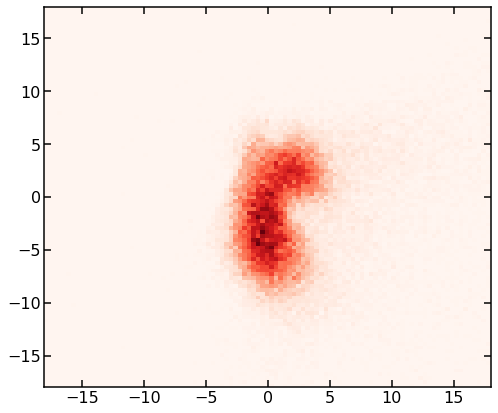

In [24]:
bins = np.linspace(-18,18,100)
plt.hist2d(z_last_fts[:,0].numpy(), y=z_last_fts[:,1].numpy(), bins=(bins, bins), cmap=plt.cm.Reds)
plt.show()

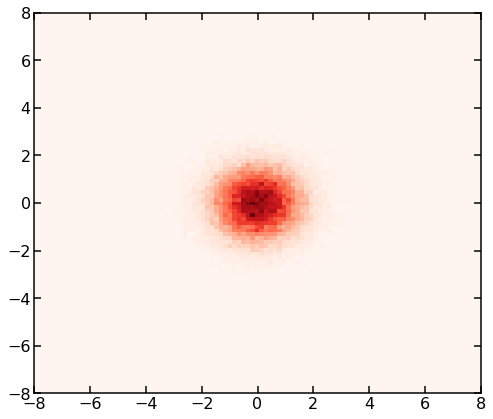

In [25]:
bins = np.linspace(-8,8,100)
plt.hist2d(z_0_fts[:,0].numpy(), y=z_0_fts[:,1].numpy(), bins=(bins, bins), cmap=plt.cm.Reds)
plt.show()

In [164]:
loss_ftn_obj = losses.LossFunction('vae_loss_mse_coord',beta=0.00001,device=device)

loss_tot,loss_reco,loss_kl = train.test(model, dataloaders['train'], len(dataloaders['train'].dataset), dataloaders['train'].batch_size, loss_ftn_obj)
















  0%|          | 0/7.8125 [00:00<?, ?it/s]














valid loss tot = 0.1775368,valid loss reco = 0.1761751,valid loss kl = 136.3438721:   0%|          | 0/7.8125 [00:00<?, ?it/s]














valid loss tot = 0.1775368,valid loss reco = 0.1761751,valid loss kl = 136.3438721:   0%|          | 0/7.8125 [00:00<?, ?it/s]














valid loss tot = 0.1521575,valid loss reco = 0.1508970,valid loss kl = 126.1969223:   0%|          | 0/7.8125 [00:00<?, ?it/s]














valid loss tot = 0.1521575,valid loss reco = 0.1508970,valid loss kl = 126.1969223:   0%|          | 0/7.8125 [00:00<?, ?it/s]














valid loss tot = 0.1627861,valid loss reco = 0.1614162,valid loss kl = 137.1499939:   0%|          | 0/7.8125 [00:00<?, ?it/s]














valid loss tot = 0.1627861,valid loss reco = 0.1614162,valid loss kl = 137.1499939:   0%|          | 0/7.8125 [00:00<?, ?it/s]














valid loss tot = 0.1753876,valid loss reco = 0.1739671,valid loss kl = 142.2279358

shape  torch.Size([6504, 4]) torch.Size([6504, 7])
shape  torch.Size([6813, 4]) torch.Size([6813, 7])
shape  torch.Size([6583, 4]) torch.Size([6583, 7])
shape  torch.Size([6376, 4]) torch.Size([6376, 7])
shape  torch.Size([6639, 4]) torch.Size([6639, 7])
shape  torch.Size([6642, 4]) torch.Size([6642, 7])
shape  torch.Size([6736, 4]) torch.Size([6736, 7])
shape  torch.Size([5275, 4]) torch.Size([5275, 7])


In [172]:
for data in dataloaders['train']:
    print(data.edge_index.shape)
    break

torch.Size([2, 389804])
